## GoogleLeak

In [23]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "GoogleLeak",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 8, 25, 3, 15, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 8, 25, 3, 45, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

1716769950 HTTP ERROR: Couldn't connect to server (7)
2024-05-27 09:32:30 430275: bs_transport_file.c:39: ERROR: Could not open http://data.ris.ripe.net/rrc06/2017.08/updates.20170824.2055.gz for reading
2024-05-27 09:32:30 430275: bgpstream_transport.c:97: ERROR: Could not open resource (http://data.ris.ripe.net/rrc06/2017.08/updates.20170824.2055.gz)
2024-05-27 09:32:30 430275: bgpstream_reader.c:169: WARNING: Could not open (http://data.ris.ripe.net/rrc06/2017.08/updates.20170824.2055.gz). Attempt 1 of 5


Processing queue: finish
Computation time: 0h 7m 54s


# Statistical features extraction

In [91]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 4
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/4 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 4s


In [92]:
import pandas as pd 
data = pd.read_json(folder+"anomaly/GoogleLeak/transform/Features/Features_1.json")
data

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
0,668,62,457,108,0,299,52,12,2,61,...,0,0,0,0,0,0,0,156,301,1054
1,964,127,582,269,0,329,102,12,3,356,...,0,0,0,0,0,0,0,180,402,1073
2,758,73,592,79,0,180,56,13,4,167,...,0,0,0,0,0,0,0,259,333,1054
3,565,47,376,82,0,202,32,14,3,62,...,0,0,0,0,0,0,0,167,209,1093
4,603,87,480,60,0,173,85,15,3,62,...,0,0,0,0,0,0,0,206,274,1073
5,990,41,469,433,0,304,33,11,3,356,...,0,0,0,0,0,0,0,182,287,1073
6,1037,89,495,157,0,514,63,13,2,140,...,0,0,0,0,0,0,0,193,302,1157
7,3580,91,921,154,0,2574,80,8,1,339,...,2,12,0,0,0,0,0,320,601,1135
8,51197,71,1025,4669,0,47795,62,14,1,5444,...,6,0,0,0,0,0,0,279,746,1093
9,29654,64,877,2087,0,28992,50,10,1,16434,...,1,1,0,1,0,0,0,206,671,1000


In [93]:
data.describe()

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
count,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000
mean,7112.300000,3252.300000,1768.200000,1217.733333,0.0,5611.600000,3228.333333,13.000000,2.100000,1540.233333,...,4.633333,2.633333,1.633333,0.266667,0.0,0.233333,6.366667,684.933333,1083.266667,1068.733333
std,13811.768116,9388.472716,2263.405222,2448.095614,0.0,12228.219394,9387.689526,2.741759,0.844863,3268.305642,...,13.699945,5.320639,4.649682,0.583292,0.0,0.678911,6.784787,933.954179,1359.886099,40.122170
min,496.000000,30.000000,317.000000,60.000000,0.0,173.000000,25.000000,8.000000,1.000000,36.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,84.000000,200.000000,1000.000000
25%,936.750000,64.500000,516.750000,82.500000,0.0,310.250000,52.250000,11.250000,1.250000,104.250000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,190.750000,309.750000,1040.500000
50%,1352.000000,89.500000,932.000000,162.000000,0.0,700.500000,71.000000,12.000000,2.000000,347.500000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.500000,285.000000,572.500000,1073.000000
75%,4576.000000,395.250000,2130.250000,471.250000,0.0,2438.250000,359.250000,14.000000,3.000000,943.000000,...,4.000000,2.000000,1.000000,0.000000,0.0,0.000000,14.000000,620.250000,1240.750000,1093.000000
max,54247.000000,38414.000000,11283.000000,10913.000000,0.0,47795.000000,38374.000000,19.000000,4.000000,16434.000000,...,75.000000,23.000000,25.000000,2.000000,0.0,3.000000,14.000000,4415.000000,6868.000000,1157.000000


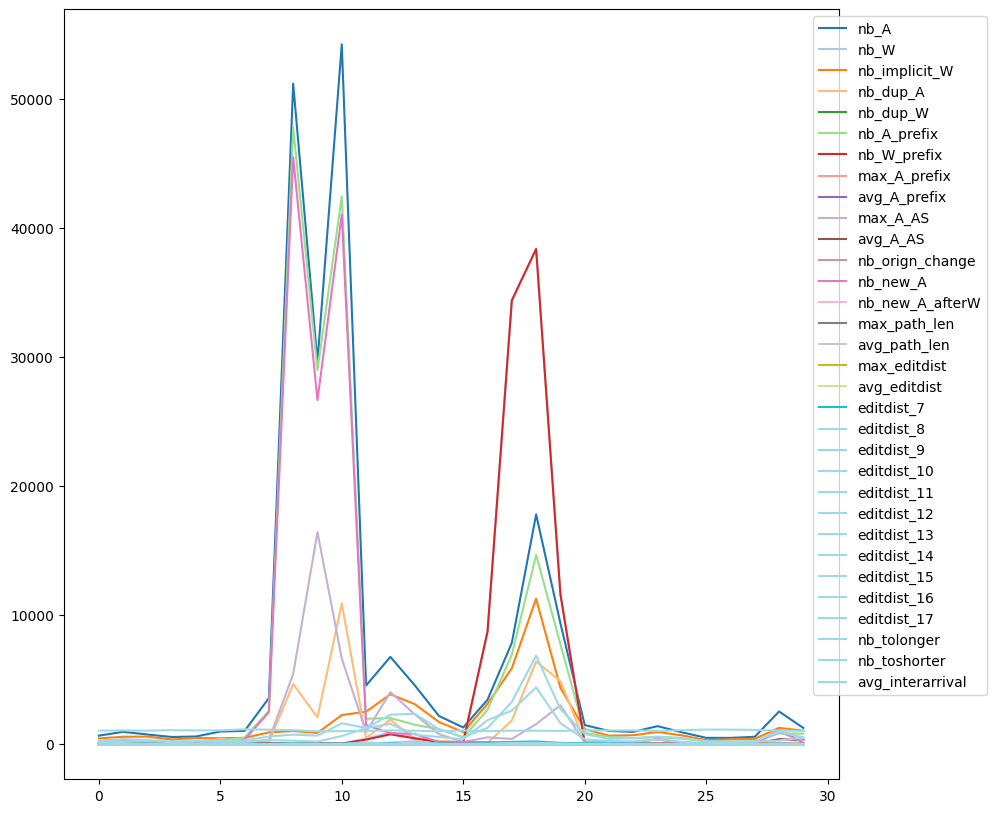

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/GoogleLeak/transform/Features/Features_1.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()


In [96]:
import pandas as pd
import datetime

data = pd.read_json(folder+"anomaly/GoogleLeak/transform/Features/Features_1.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 8, 25, 3, 15, 0)  # Start time
end_time = datetime.datetime(2017, 8, 25, 3, 45, 0)   # End time

# Generate a list of timestamps for each minute between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='T')  # 'T' frequency is for minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Display the DataFrame to verify
print(data.head())
# Save the updated DataFrame to a new JSON file if needed
data.to_json(folder + "anomaly/GoogleLeak/transform/Features/google_leak_main.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 30
            timestamp  nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0 2017-08-25 03:15:00   668    62            457       108         0   
1 2017-08-25 03:16:00   964   127            582       269         0   
2 2017-08-25 03:17:00   758    73            592        79         0   
3 2017-08-25 03:18:00   565    47            376        82         0   
4 2017-08-25 03:19:00   603    87            480        60         0   

   nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...  editdist_11  \
0          299           52            12             2  ...            0   
1          329          102            12             3  ...            0   
2          180           56            13             4  ...            0   
3          202           32            14             3  ...            0   
4          173           85            15             3  ...            0   

   editdist_12  editdist_13  editdist_14  editdist_15  editdist_16  

### RIBs

In [63]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
    "UseRibsData": True,
    "UseRibsPriming": True,
})

dataset.setPeriodsOfInterests([
    {
    "name": "GoogleLeak_ribs",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 8, 25, 3, 15, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 8, 25, 3, 45, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 6m 38s


In [64]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 2
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/2 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 9s


In [65]:
import pandas as pd 
data = pd.read_json(folder+"anomaly/GoogleLeak_ribs/transform/Features/Features_1.json")
data

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
0,668,62,504,115,0,299,52,12,2,61,...,0,0,0,0,0,0,0,173,331,1054
1,964,127,594,274,0,329,102,12,3,356,...,0,0,0,0,0,0,0,190,404,1073
2,758,73,613,91,0,180,56,13,4,167,...,0,0,0,0,0,0,0,272,341,1054
3,565,47,397,83,0,202,32,14,3,62,...,0,0,0,0,0,0,0,183,214,1093
4,603,87,513,73,0,173,85,15,3,62,...,0,0,0,0,0,0,0,214,299,1073
5,990,41,496,439,0,304,33,11,3,356,...,0,0,0,0,0,0,0,199,297,1073
6,1037,89,797,195,0,514,63,13,2,140,...,2,1,0,0,0,0,0,343,454,1157
7,3580,91,2069,256,0,2574,80,8,1,339,...,2,12,0,0,0,0,0,493,1576,1135
8,51197,71,8107,4723,0,47795,62,14,1,5444,...,113,0,3,1,0,0,0,468,7639,1093
9,29654,64,4927,2234,0,28992,50,10,1,16434,...,3,1,2,2,0,1,0,553,4374,1000


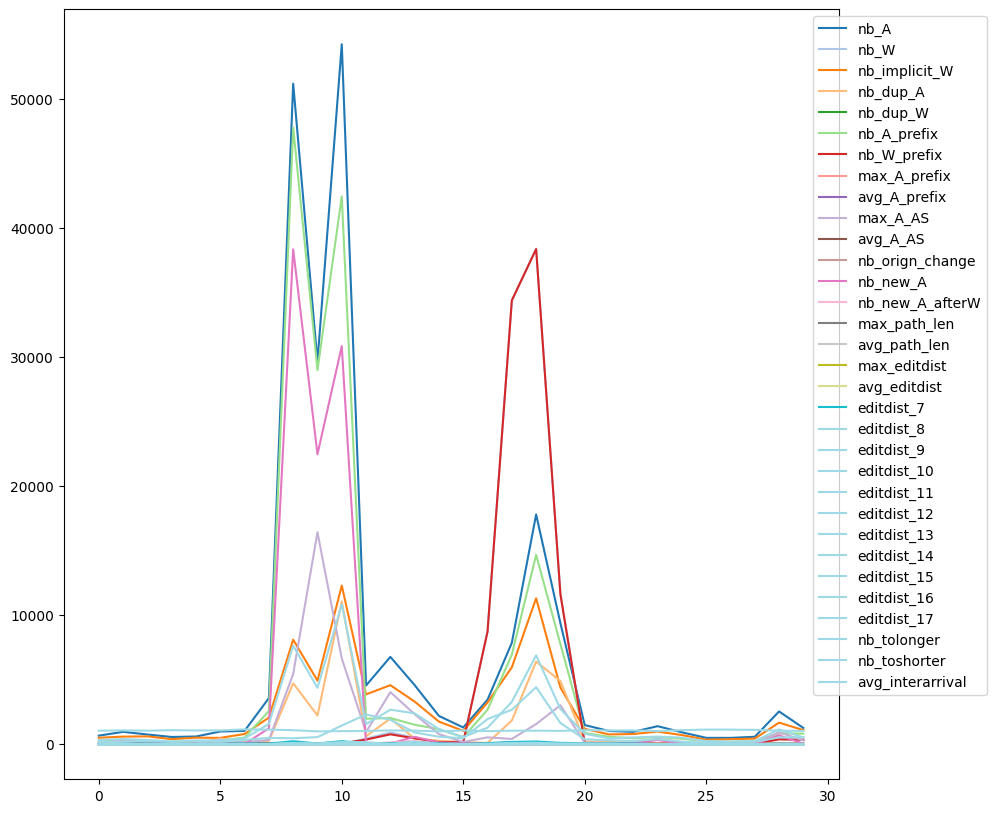

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder+"anomaly/GoogleLeak_ribs/transform/Features/Features_1.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

## February 2021 Cablevision Mexico

In [67]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views.sg", "route-views.eqix"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "Mexico_cable",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2021, 2, 11, 4, 30, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2021, 2, 11, 6, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 22m 9s


In [68]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 58s


In [69]:
data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_1.json")
data

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
0,39212,878,19605,17449,46,13080,468,1490,3,2979,...,57,135,20,1,18,0,2,6736,12869,1000
1,27222,1113,11972,12954,36,10572,573,889,3,1776,...,33,21,0,0,2,0,2,4230,7742,1000
2,27414,3677,15389,8206,133,10597,2232,972,3,2443,...,39,30,0,0,4,0,2,6247,9142,1000
3,25853,985,8271,14060,71,9670,327,1473,3,2922,...,14,19,36,3,2,0,8,1432,6839,1000
4,47831,1831,18316,22054,54,13982,850,1303,3,2585,...,72,55,180,25,27,36,12,6981,11335,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,36682,1407,14751,20336,95,15527,306,1099,2,2192,...,25,67,10,4,9,0,0,4770,9981,1000
86,52293,1518,21374,27918,137,19393,360,1397,3,2714,...,41,17,22,7,20,2,1,8539,12835,1000
87,23341,1883,10131,11507,92,6270,308,1278,4,4218,...,25,16,1,2,1,0,0,3507,6624,1000
88,52168,2364,15368,30196,115,17478,649,1168,3,6798,...,21,13,1,0,15,0,0,3225,12143,1000


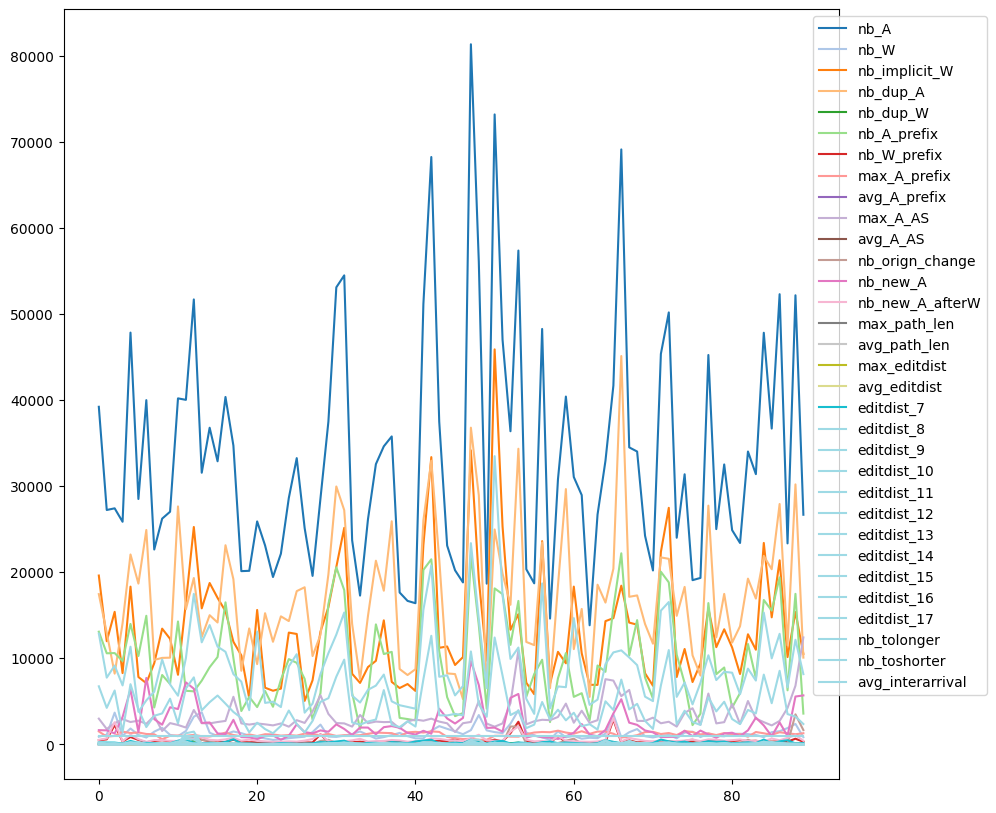

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_1.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import datetime

data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_1.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2021, 2, 11, 4, 30, 0)  # Start time
end_time = datetime.datetime(2021, 2, 11, 6, 0, 0)    # End time

# Generate a list of timestamps for each minute between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='T')  # 'T' frequency is for minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Display the DataFrame to verify
print(data.head())
# Save the updated DataFrame to a new JSON file if needed
data.to_json(folder + "anomaly/Mexico_cable/transform/Features/mexico_cable_features.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 90
            timestamp   nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0 2021-02-11 00:00:00  39212   878          19605     17449        46   
1 2021-02-11 00:01:00  27222  1113          11972     12954        36   
2 2021-02-11 00:02:00  27414  3677          15389      8206       133   
3 2021-02-11 00:03:00  25853   985           8271     14060        71   
4 2021-02-11 00:04:00  47831  1831          18316     22054        54   

   nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...  editdist_11  \
0        13080          468          1490             3  ...           57   
1        10572          573           889             3  ...           33   
2        10597         2232           972             3  ...           39   
3         9670          327          1473             3  ...           14   
4        13982          850          1303             3  ...           72   

   editdist_12  editdist_13  editdist_14  editdist_15  editdis

## April 2018: 1300 IP addresses within Amazon Web Services space were hijacked by eNet

In [82]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc00", "rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "Amazon_enet",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2018, 4, 25, 8, 30, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2018, 4, 25, 12, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 18m 1s


In [98]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 4
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/4 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 4s


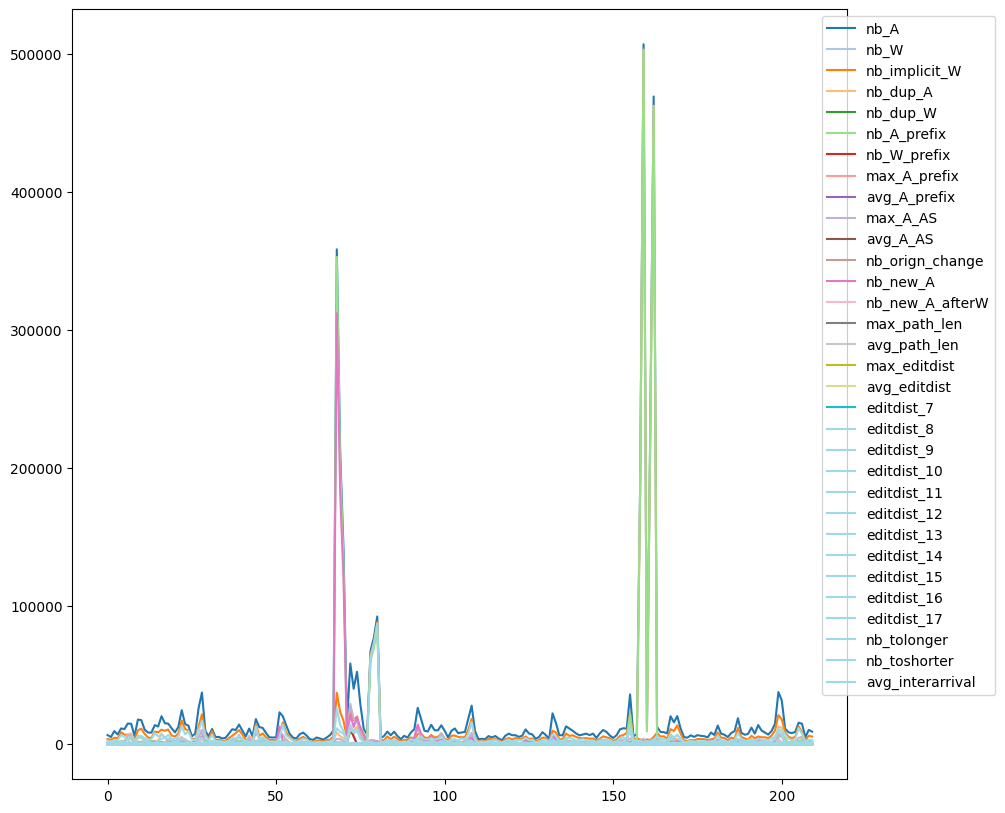

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/Amazon_enet/transform/Features/Features_1.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [104]:
import pandas as pd
import datetime

data = pd.read_json(folder + "anomaly/Amazon_enet/transform/Features/Features_1.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2018, 4, 25, 8, 30, 0)  # Start time
end_time = datetime.datetime(2018, 4, 25, 12, 0, 0)    # End time

# Generate a list of timestamps for each minute between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='T')  # 'T' frequency is for minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Display the DataFrame to verify
print(data.head())
# Save the updated DataFrame to a new JSON file if needed
data.to_json(folder + "anomaly/Amazon_enet/transform/Features/amazon_enet_main.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 210
            timestamp   nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0 2018-04-25 08:30:00   6685   559           3816      1912         1   
1 2018-04-25 08:31:00   5242   581           3242      1123         0   
2 2018-04-25 08:32:00   9567   891           4762      1712         0   
3 2018-04-25 08:33:00   7082   935           4228      1304         0   
4 2018-04-25 08:34:00  11446  1345           8778      1403         0   

   nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...  editdist_11  \
0          518          126            74            13  ...           34   
1          391          165           124            13  ...           13   
2          577          254            79            17  ...           28   
3          577          150            69            12  ...           10   
4         2521          185           103             5  ...           32   

   editdist_12  editdist_13  editdist_14  editdist_15  editdi

## December 2017: Eighty high-traffic prefixes normally announced by Google, Apple, Facebook

In [88]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views2", "route-views3", "route-views4", "ris-ripe"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "high_traffic_prefixes_FANG",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 12, 12, 6, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 12, 12, 8, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 31m 0s


In [105]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 4
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/4 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 4s


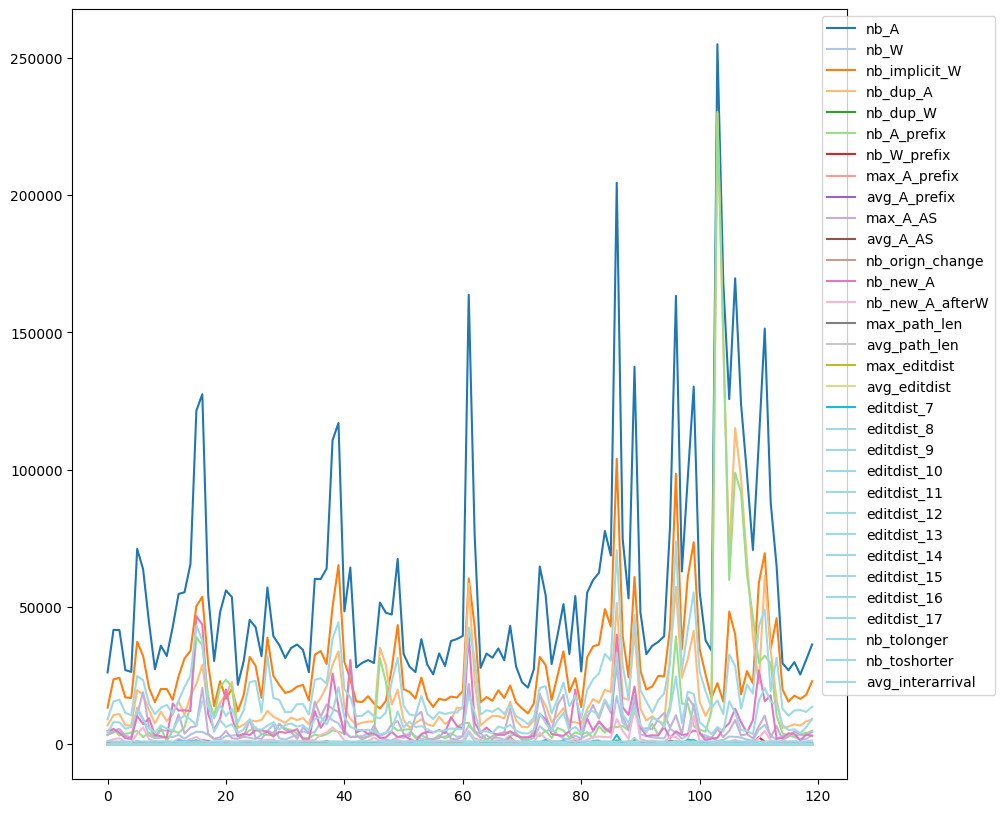

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/high_traffic_prefixes_FANG/transform/Features/Features_1.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [107]:
import pandas as pd
import datetime

data = pd.read_json(folder + "anomaly/high_traffic_prefixes_FANG/transform/Features/Features_1.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 12, 12, 6, 0, 0) # Start time
end_time = datetime.datetime(2017, 12, 12, 8, 0, 0)    # End time

# Generate a list of timestamps for each minute between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='T')  # 'T' frequency is for minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Display the DataFrame to verify
print(data.head())

# Save the updated DataFrame to a new JSON file if needed
data.to_json(folder + "anomaly/high_traffic_prefixes_FANG/transform/Features/high_traffic_FANG_main.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 120
            timestamp   nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0 2017-12-12 06:00:00  26151  3381          13345      6885       288   
1 2017-12-12 06:01:00  41654  5060          23626     10649       362   
2 2017-12-12 06:02:00  41581  5623          24208     11013       530   
3 2017-12-12 06:03:00  27025  2912          17062      6938       182   
4 2017-12-12 06:04:00  26336  2304          16861      6812       212   

   nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...  editdist_11  \
0         3433          337           286             8  ...            4   
1         5678          288           448             7  ...          224   
2         3215          440           410            13  ...           29   
3         3784          238           374             7  ...          116   
4         4248          261           337             6  ...           79   

   editdist_12  editdist_13  editdist_14  editdist_15  editdi

In [109]:
data.columns

Index(['timestamp', 'nb_A', 'nb_W', 'nb_implicit_W', 'nb_dup_A', 'nb_dup_W',
       'nb_A_prefix', 'nb_W_prefix', 'max_A_prefix', 'avg_A_prefix',
       'max_A_AS', 'avg_A_AS', 'nb_orign_change', 'nb_new_A',
       'nb_new_A_afterW', 'max_path_len', 'avg_path_len', 'max_editdist',
       'avg_editdist', 'editdist_7', 'editdist_8', 'editdist_9', 'editdist_10',
       'editdist_11', 'editdist_12', 'editdist_13', 'editdist_14',
       'editdist_15', 'editdist_16', 'editdist_17', 'nb_tolonger',
       'nb_toshorter', 'avg_interarrival'],
      dtype='object')

# Graph features extraction

In [60]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "GraphFeatures")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 1s


In [87]:
import pandas as pd 
data = pd.read_json(folder+"/anomaly/GoogleLeak/transform/GraphFeatures/GraphFeatures_1.json")
data

,eigenvector,pagerank,clustering,triangles,degree,degree_centrality,average_neighbor_degree,node_clique_number,number_of_cliques,nb_of_nodes,nb_of_edges,diameter,assortativity,percolation_limit
0,0.004517,0.000181,0.042118,0.566256,2.698407,0.000489,55.053691,2.141564,2.595945,5524,7453,14,-0.094590,0.980567
1,0.004515,0.000181,0.042097,0.567944,2.697868,0.000488,55.435582,2.141308,2.595772,5534,7465,14,-0.094936,0.980692
2,0.004508,0.000181,0.041782,0.558186,2.694977,0.000487,55.219771,2.140043,2.591435,5534,7457,14,-0.094503,0.980580
3,0.004512,0.000181,0.041589,0.567016,2.697977,0.000487,55.496830,2.141077,2.596460,5536,7468,14,-0.094707,0.980664
4,0.004508,0.000181,0.041904,0.557564,2.695825,0.000487,55.035416,2.140611,2.590819,5533,7458,14,-0.094388,0.980568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.003509,0.000122,0.038637,0.510921,2.666504,0.000325,65.348040,2.128737,2.572544,8195,10926,14,-0.109811,0.982398
57,0.003513,0.000122,0.039157,0.522026,2.667236,0.000326,65.725117,2.130689,2.574009,8195,10929,14,-0.109826,0.982511
58,0.003503,0.000122,0.038472,0.510610,2.664390,0.000325,65.601612,2.127927,2.570976,8200,10924,14,-0.109534,0.982451
59,0.003515,0.000122,0.039331,0.521511,2.668860,0.000325,65.752826,2.129311,2.577940,8205,10949,14,-0.109496,0.982539


In [88]:
# Define thresholds for anomalies
# You can adjust these thresholds based on your specific requirements
threshold_edges = data['nb_of_edges'].mean() * 1.5
threshold_nodes = data['nb_of_nodes'].mean() * 1.5
threshold_avg_neighbor_degree = data['average_neighbor_degree'].mean() * 1.5

# Create a new column 'anomaly' with 1 indicating an anomaly and 0 indicating normal
data['anomaly'] = ((data['nb_of_edges'] > threshold_edges) |
                 (data['nb_of_nodes'] > threshold_nodes) |
                 (data['average_neighbor_degree'] > threshold_avg_neighbor_degree)).astype(int)


# data.to_csv('bgp_graph_features_with_anomaly.csv', index=False)


In [82]:
anomaly_count = data['anomaly'].sum()
anomaly_count

9

<Axes: >

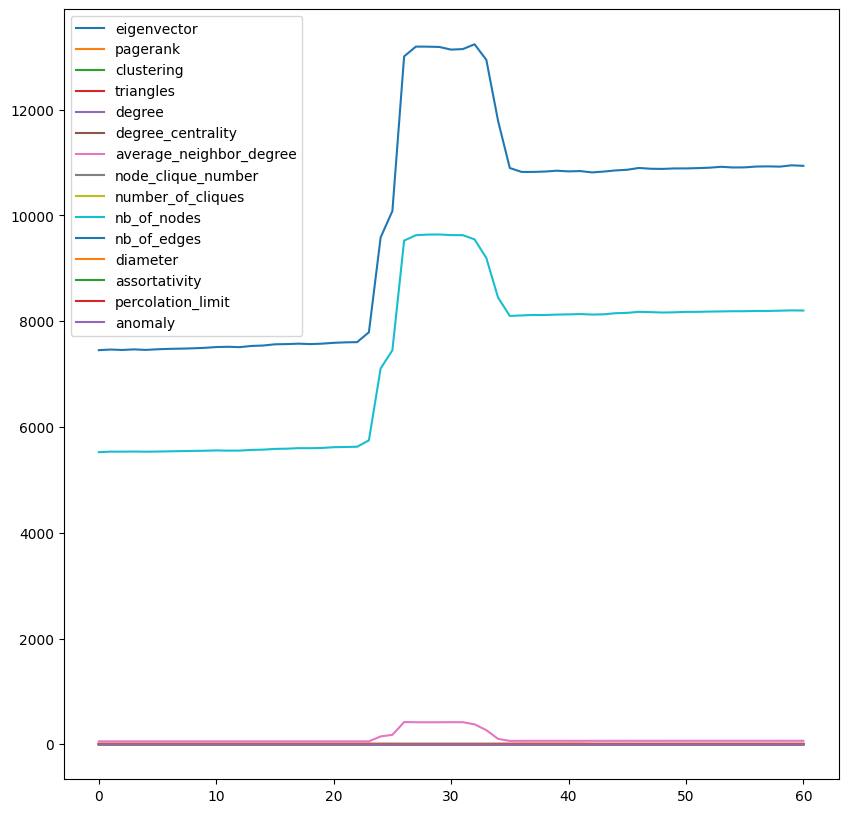

In [89]:
data.plot(figsize=(10,10))

## Hijacking

In [130]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "BalancerHijack",
    "label": "hijack",
    "start_time": utils.getTimestamp(2023, 9, 20, 0, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2023, 9, 20, 10, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 1s


In [131]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 3s


<Axes: >

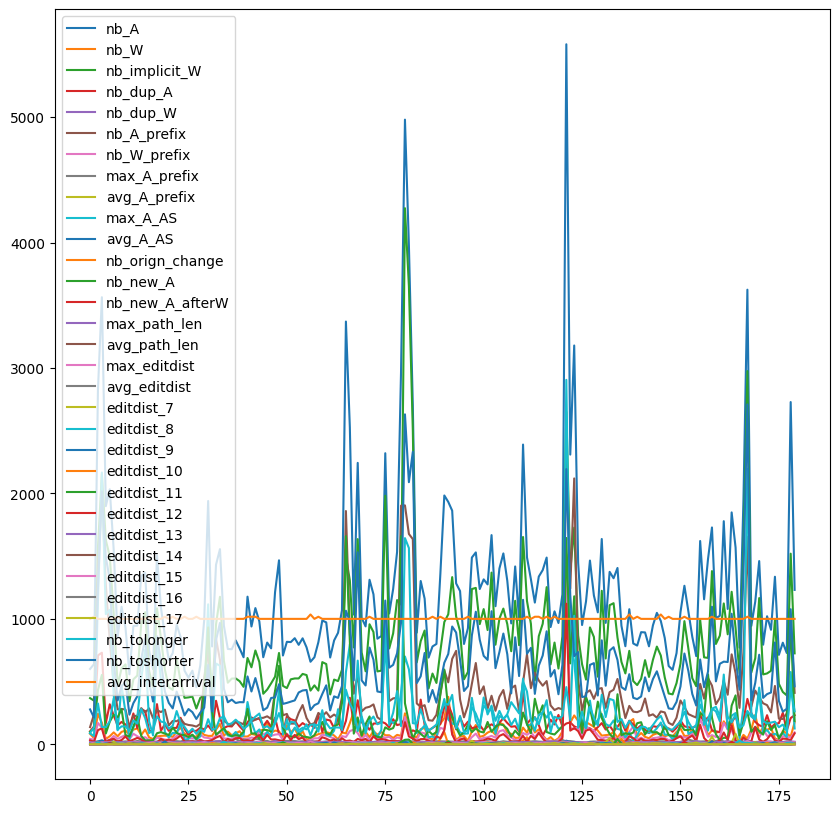

In [132]:
import pandas as pd 
data = pd.read_json(folder+"/hijack/BalancerHijack/transform/Features/Features_1.json")
data.plot(figsize=(10,10))

In [133]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "RoutesFeatures")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs")

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 1h 1m 24s


<Axes: >

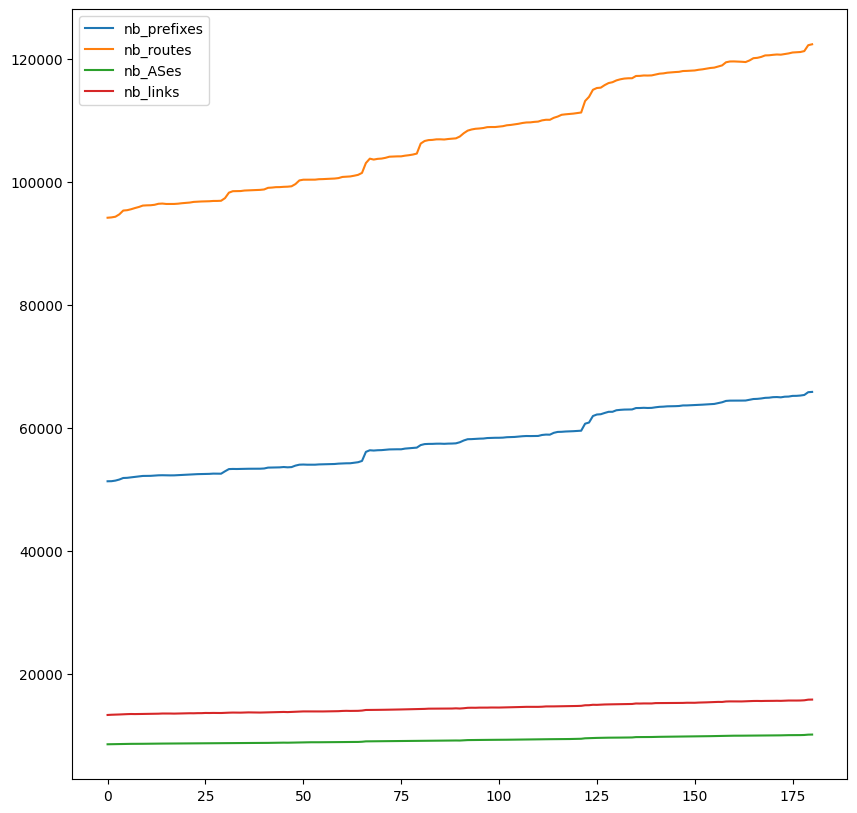

In [134]:
import pandas as pd 
data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/hijack/BalancerHijack/transform/RoutesFeatures/RoutesFeatures_1.json")
data.plot(figsize=(10,10))

In [114]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "HijackAnalyze")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs")

################
# Run jobs list 
################
Number of processes to execute: 2
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/2 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 22s


In [ ]:
import pandas as pd 
data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/hijack/BalancerHijack/transform/RoutesFeatures/RoutesFeatures_1.json")
data.plot(figsize=(10,10))

## BalancerHijackFull

In [127]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "BalancerHijackFull",
    "label": "hijack",
    "start_time": utils.getTimestamp(2023, 9, 20, 0, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2023, 9, 21, 0, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 21m 19s


In [128]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 55s


<Axes: >

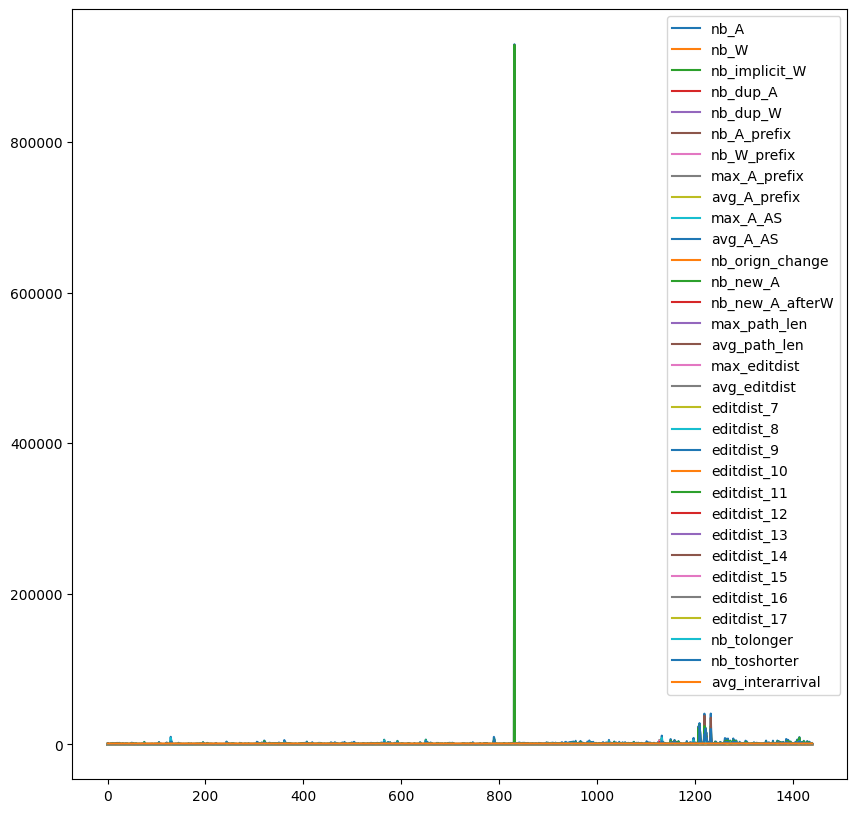

In [129]:
import pandas as pd 
data = pd.read_json(folder+"/hijack/BalancerHijackFull/transform/Features/Features_1.json")
data.plot(figsize=(10,10))